# Random Label Code

## Import Libraries and Set Device

In [1]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda


## Hyperparameters and Load Data

In [3]:
# Hyperparameters
#input_size = 784  # 28x28 flattened images
num_classes = 10
num_epochs = 150
batch_size = 64
learning_rate = 0.001

In [4]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

In [5]:
### shuffle labels
train_images = torch.tensor(()).to(device)
train_labels = []
for image, label in train_dataset:
    train_images = torch.cat((train_images,image.to(device)),0)
    train_labels.append(label)
test_images = torch.tensor(()).to(device)
test_labels = []
for image, lable in test_dataset:
    test_images = torch.cat((test_images,image.to(device)),0)
    test_labels.append(label)

train_labels = torch.tensor(train_labels).to(device)
test_labels = torch.tensor(test_labels).to(device)
random.shuffle(train_labels)
random.shuffle(test_labels)
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])
torch.Size([10000])


In [6]:
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=TensorDataset(train_images,train_labels), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=TensorDataset(test_images,test_labels), batch_size=batch_size, shuffle=False)

## View Image

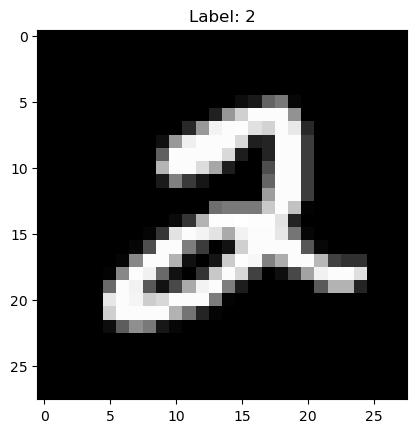

In [7]:
# Choose an image index
image_index = 5  # You can change this to any valid index

# Get the image and label
image, label = train_dataset[image_index]

# Convert the image tensor to a numpy array
image_array = image.numpy()

# Reshape the array to 28x28
image_array = image_array.reshape(28, 28)

# Display the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Model Class

In [8]:
# CNN model
class CNN(nn.Module):
    def __init__(self, num_classes, out_channels_1, out_channels_2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=out_channels_1, kernel_size=3, padding=1),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=out_channels_1, out_channels=out_channels_2,
                                             kernel_size=3, padding=1),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.ReLU())
        self.fc = nn.Linear(out_channels_2 * 7 * 7, num_classes)  # Assuming input images are 28x28


    def forward(self, x):
       x = x.unsqueeze(1)
       x = self.conv1(x)
       x = self.conv2(x)
       x = x.view(x.size(0), -1)
       x = self.fc(x)
       return x

## Train and Evaluation

In [9]:
### training function
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # model to device
    model = model.to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss_train = []
    total_loss_test = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss_train.append(train_loss)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}; train loss: {train_loss}")

        #Validation
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss * images.size(0)
        test_loss = test_loss/len(test_loader.sampler)
        total_loss_test.append(test_loss)
        
    return total_loss_train, total_loss_test


In [10]:
CNN_1 = CNN(num_classes=num_classes, out_channels_1=16, out_channels_2=32).to(device)

In [11]:
### Train models
CNN_1_loss_train, CNN_1_loss_test = train_eval(model = CNN_1, num_epochs=num_epochs, learning_rate=learning_rate,
                                        train_loader=train_loader, test_loader=test_loader)

Epoch: 0; train loss: 2.3010268211364746
Epoch: 10; train loss: 2.2986338138580322
Epoch: 20; train loss: 2.2844133377075195
Epoch: 30; train loss: 2.2730448246002197
Epoch: 40; train loss: 2.2650887966156006
Epoch: 50; train loss: 2.2598509788513184
Epoch: 60; train loss: 2.2559361457824707
Epoch: 70; train loss: 2.252382278442383
Epoch: 80; train loss: 2.2494003772735596
Epoch: 90; train loss: 2.2468771934509277
Epoch: 100; train loss: 2.245013475418091
Epoch: 110; train loss: 2.241468667984009
Epoch: 120; train loss: 2.239147663116455
Epoch: 130; train loss: 2.2369813919067383
Epoch: 140; train loss: 2.2354886531829834


## Plot

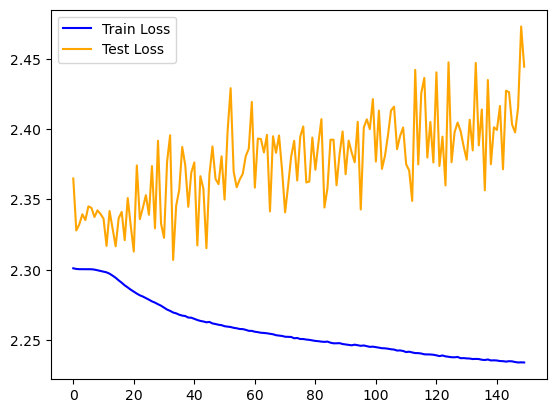

In [13]:
# Loss Plot
CNN_1_loss_train = torch.tensor(CNN_1_loss_train).cpu().data.numpy()
CNN_1_loss_test = torch.tensor(CNN_1_loss_test).cpu().data.numpy()
plt.plot(np.arange(0, len(CNN_1_loss_train), 1), CNN_1_loss_train, label = "Train Loss", color = "blue")
plt.plot(np.arange(0, len(CNN_1_loss_test), 1), np.array(CNN_1_loss_test), label = "Test Loss", color = "orange")
plt.legend()
plt.show()